### Animal Image Classification using Convolutional Neural Network

Importing necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install q keras==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time

Looking up our image dataset

In [ ]:
#Default dimensions 
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/train'  
validation_data_dir = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/train'  
test_data_dir = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test'
   
# number of epochs to train top model  
epochs = 7

# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [ ]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

Creation of weights/features with VGG16

In [ ]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode=None,
shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1685 images belonging to 20 classes.


<ipython-input-7-f1eb32b39b88>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)


Time:  0:15:57.378887


In [ ]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1685 images belonging to 20 classes.


<ipython-input-8-8485d3f1b9bb>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = vgg16.predict_generator(


Time:  0:00:16.952202


In [ ]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
nb_test_samples = len(generator.filenames)  
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)  
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1684 images belonging to 20 classes.


<ipython-input-9-32fa8b5a9df9>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)


Time:  0:15:06.437057


Loading training, validation and testing data

In [ ]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 1685 images belonging to 20 classes.


In [ ]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 1685 images belonging to 20 classes.


In [ ]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1684 images belonging to 20 classes.


Training of model

In [ ]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/7
34/34 [==============================] - 2s 25ms/step - loss: 2.9112 - acc: 0.1294 - val_loss: 2.3728 - val_acc: 0.4546
Epoch 2/7
34/34 [==============================] - 0s 10ms/step - loss: 2.3645 - acc: 0.3104 - val_loss: 1.8075 - val_acc: 0.5596
Epoch 3/7
34/34 [==============================] - 0s 10ms/step - loss: 1.9674 - acc: 0.4481 - val_loss: 1.3962 - val_acc: 0.7306
Epoch 4/7
34/34 [==============================] - 0s 10ms/step - loss: 1.7077 - acc: 0.5270 - val_loss: 1.1242 - val_acc: 0.8006
Epoch 5/7
34/34 [==============================] - 1s 16ms/step - loss: 1.5145 - acc: 0.5751 - val_loss: 0.9931 - val_acc: 0.8320
Epoch 6/7
34/34 [==============================] - 1s 17ms/step - loss: 1.3782 - acc: 0.6208 - val_loss: 0.8508 - val_acc: 0.8837
Epoch 7/7
34/34 [==============================] - 0s 6ms/step - loss: 0.7460 - acc: 0.8991
[INFO] accuracy: 89.91%
[INFO] Loss: 0.7459615468978882
Time:  0:00:05.461556


In [ ]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
Total params: 2,514,970
Trainable params: 2,514,970
Non-

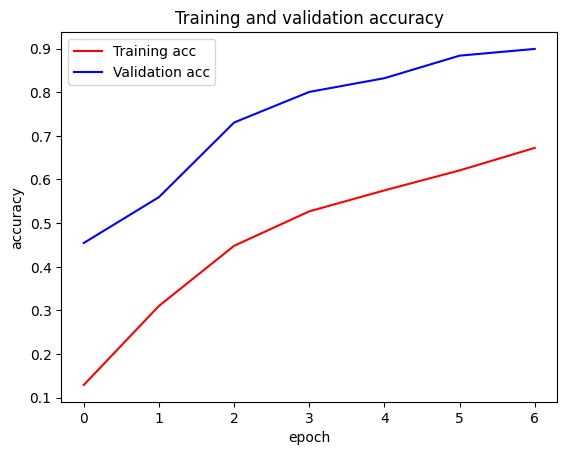

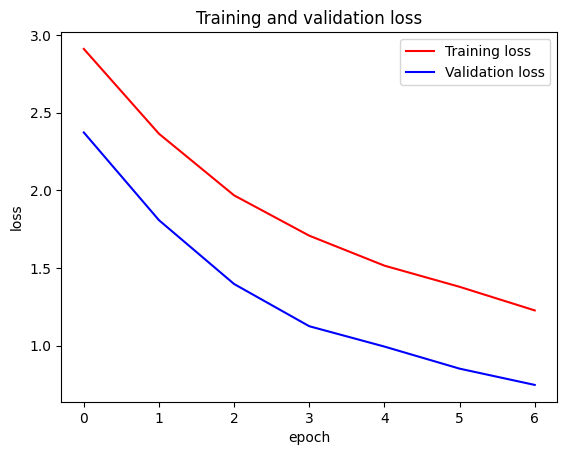

In [ ]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

Model Evaluation on Testing Set

In [ ]:
model.evaluate(test_data, test_labels)

53/53 [==============================] - 0s 6ms/step - loss: 0.9958 - acc: 0.8100


[0.9957728385925293, 0.8099762201309204]

Classification metrics

In [ ]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.         0.         0.         ... 0.         0.9752693
    0.        ]
   [0.         0.         0.83731985 ... 0.         0.63422465
    0.        ]
   [0.         0.         1.0214238  ... 0.         0.43857962
    0.        ]
   ...
   [0.         0.         1.4983234  ... 0.         0.7740118
    0.        ]
   [0.         0.         1.3512704  ... 0.         0.8303458
    0.        ]
   [0.         0.         0.11849257 ... 0.         0.54692477
    0.        ]]

  [[0.224632   0.         0.38416666 ... 0.         0.80260664
    0.        ]
   [0.42320064 0.         0.6376095  ... 0.         0.46509397
    0.        ]
   [0.24029508 0.         0.76153386 ... 0.         0.01243585
    0.        ]
   ...
   [0.06875861 0.         1.5896158  ... 0.24036732 0.45877513
    0.        ]
   [0.06579617 0.         1.5359583  ... 0.         0.8982942
    0.        ]
   [0.15450221 0.         0.5266387  ... 0.         0.65982145
    0.        ]]

  [[0.3624721  0.         0.

In [ ]:
animals = ['bear', 'butterflies', 'cats', 'cheetahs', 'chickens', 'chimpanzee', 'deer', 'dogs', 'elephants', 'goat', 
           'horses', 'hyenas', 'ox', 'panda', 'rhinoceros', 'spiders', 'squirells', 'tigers', 'wolf', 'zebra']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

        bear       1.00      0.35      0.52        60
 butterflies       0.95      0.69      0.80       100
        cats       0.99      0.70      0.82       100
    cheetahs       0.98      0.80      0.88       100
    chickens       1.00      0.40      0.57       100
  chimpanzee       1.00      0.62      0.76        60
        deer       0.00      0.00      0.00        60
        dogs       1.00      0.35      0.52       100
   elephants       0.97      0.30      0.46       100
        goat       1.00      0.62      0.76        60
      horses       0.98      0.54      0.70       100
      hyenas       1.00      0.24      0.39       100
          ox       1.00      0.05      0.10        60
       panda       0.96      0.67      0.79       100
  rhinoceros       1.00      0.22      0.36        60
     spiders       0.96      0.23      0.37       100
   squirells       1.00      0.01      0.02       104
      tigers       1.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

In [ ]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
#label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

Confusion matrix, without normalization


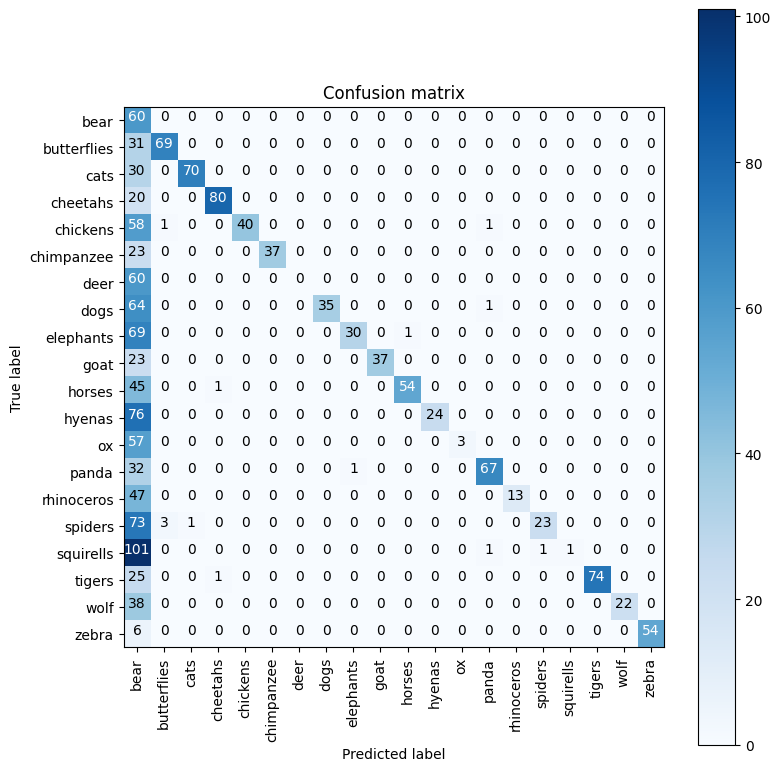

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Create a larger plot
fig, ax = plt.subplots(figsize=(8, 8))

plot_confusion_matrix(confusion_matrix, ['bear', 'butterflies', 'cats', 'cheetahs', 'chickens', 'chimpanzee', 'deer', 'dogs', 'elephants', 'goat', 'horses', 
                                         'hyenas', 'ox', 'panda', 'rhinoceros', 'spiders', 'squirells', 'tigers', 'wolf', 'zebra'], normalize=False, title='Confusion matrix')

In [ ]:
# plot_confusion_matrix(confusion_matrix, ['bear', 'butterflies', 'cats', 'cheetahs', 'chickens', 'chimpanzee', 'deer', 'dogs', 'elephants', 'goat', 'horses', 
#                                          'hyenas', 'ox', 'panda', 'rhinoceros', 'spiders', 'squirells', 'tigers', 'wolf', 'zebra'])

In [ ]:
# #Those numbers are all over the place. Now turning normalize= True
# plot_confusion_matrix(confusion_matrix, 
#                       ['bear', 'butterflies', 'cats', 'cheetahs', 'chickens', 'chimpanzee', 'deer', 'dogs', 'elephants', 'goat', 'horses', 'hyenas', 
#                        'ox', 'panda', 'rhinoceros', 'spiders', 'squirells', 'tigers', 'wolf', 'zebra'],
#                      normalize=True)

Normalized confusion matrix


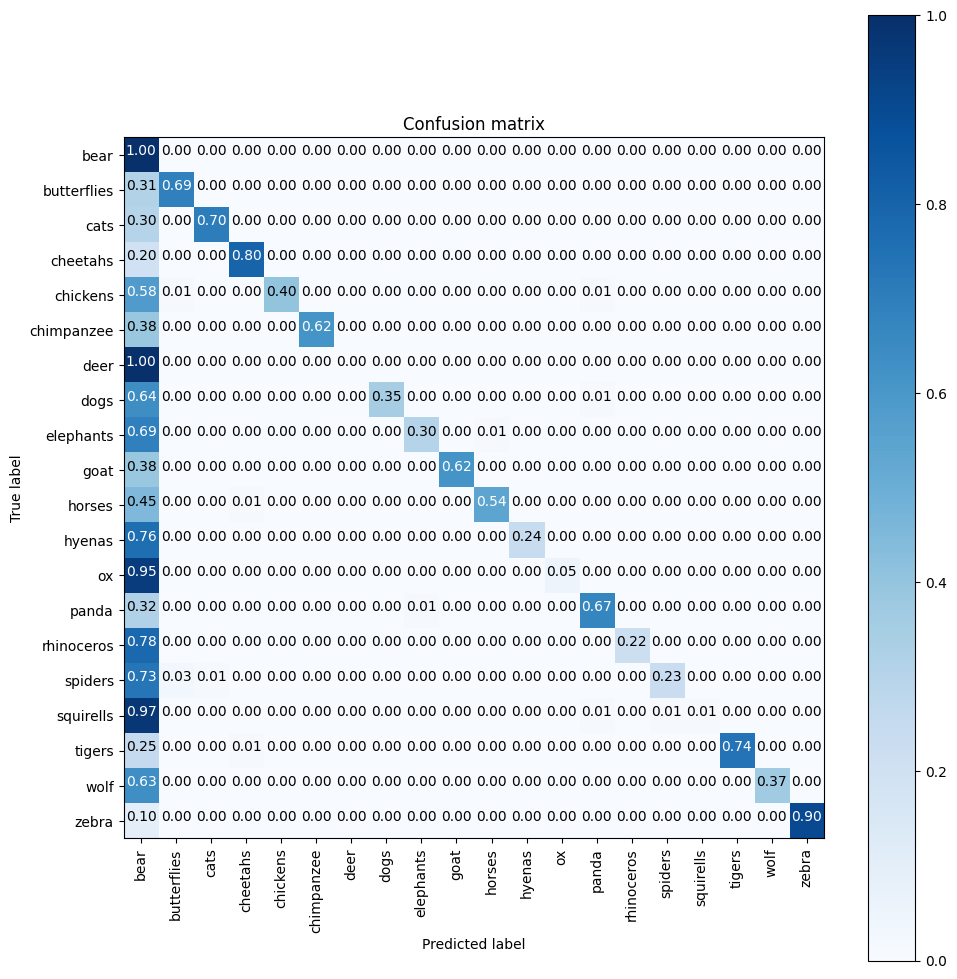

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, with normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Create a larger plot
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(confusion_matrix, ['bear', 'butterflies', 'cats', 'cheetahs', 'chickens', 'chimpanzee', 'deer', 'dogs', 'elephants', 'goat', 'horses', 
                                         'hyenas', 'ox', 'panda', 'rhinoceros', 'spiders', 'squirells', 'tigers', 'wolf', 'zebra'], normalize=True, title='Confusion matrix')

Testing images on model

In [ ]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [ ]:
import numpy as np 
from keras.models import Sequential 
from keras.layers import Dense 

# create the model
model = Sequential()
# model.add(keras.layers.Flatten(input_shape=(32,32,3)))
model.add(Dense(10, input_dim=5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# generate some dummy data
X = np.random.rand(100, 5)
y = np.random.randint(2, size=(100,))

# train the model
model.fit(X, y, epochs=10, batch_size=32)

# make predictions and get probabilities
probas = model.predict(X)
y_pred = np.round(probas)

Epoch 1/10
4/4 [==============================] - 0s 5ms/step - loss: 0.7062 - accuracy: 0.4600
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7050 - accuracy: 0.4800
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7040 - accuracy: 0.4900
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7031 - accuracy: 0.5100
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7023 - accuracy: 0.5200
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5100
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.5200
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 0.6999 - accuracy: 0.5200
Epoch 9/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5200
Epoch 10/10
4/4 [==============================] - 0s 3ms/step


35363/35363 [==============================] - 0s 0us/step
The name of the fauna is -> cheetah
<dtype: 'uint8'>


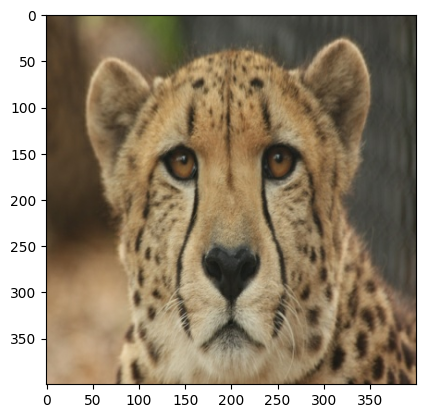

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image


# Load pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Define a function to predict the animal name from an image file
def predict_animal(image_path):
    # Load the image and resize it to the input size of VGG16 (224x224)
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert the image to a numpy array
    x = image.img_to_array(img)
    # Preprocess the image by subtracting the mean RGB values of the ImageNet dataset
    x = preprocess_input(x)
    # Reshape the image to a batch of size 1 (required by VGG16)
    x = np.expand_dims(x, axis=0)
    # Use the VGG16 model to predict the probabilities of each class
    preds = model.predict(x)
    # Decode the predicted class label from the top-1 class index
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    # Return the predicted animal name
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/cheetah_007_val_resized.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()


1/1 [==============================] - 0s 140ms/step
The name of the fauna is -> chimpanzee
<dtype: 'uint8'>


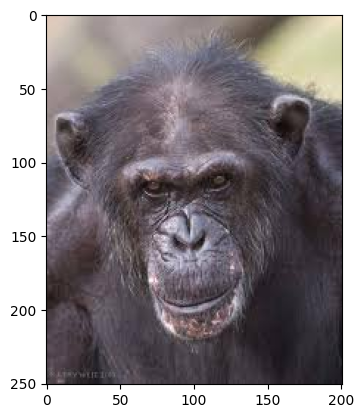

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/chimpanzee.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()


1/1 [==============================] - 0s 146ms/step
The name of the fauna is -> ox
<dtype: 'uint8'>


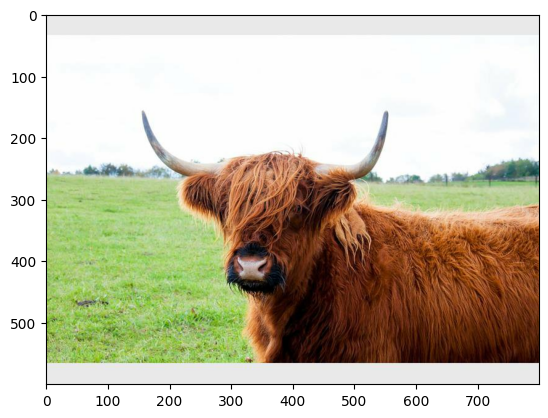

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/oxImage.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()


1/1 [==============================] - 0s 139ms/step
The name of the fauna is -> hyena
<dtype: 'uint8'>


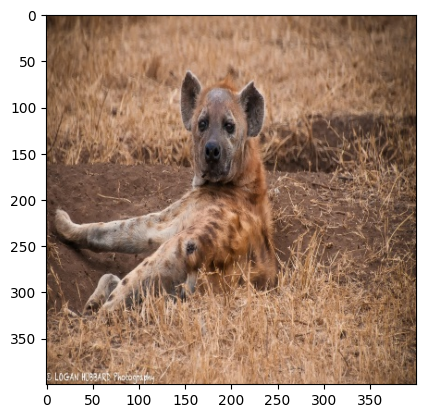

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/hyena_016_val_resized.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()


1/1 [==============================] - 0s 141ms/step
The name of the fauna is -> giant_panda
<dtype: 'uint8'>


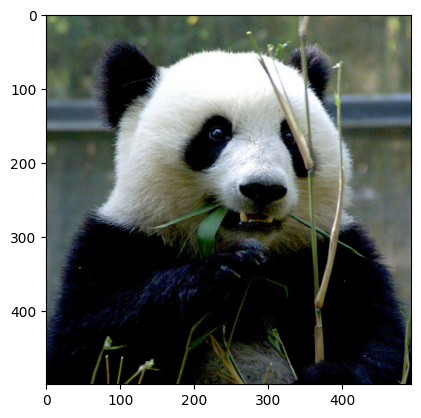

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/panda_00021.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()


1/1 [==============================] - 0s 162ms/step
The name of the fauna is -> tiger
<dtype: 'uint8'>


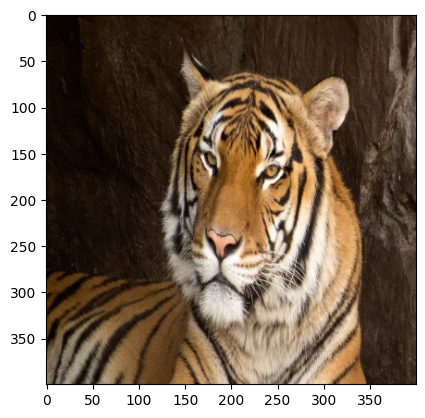

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/tiger_010_val_resized.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()


1/1 [==============================] - 0s 150ms/step
The name of the fauna is -> timber_wolf
<dtype: 'uint8'>


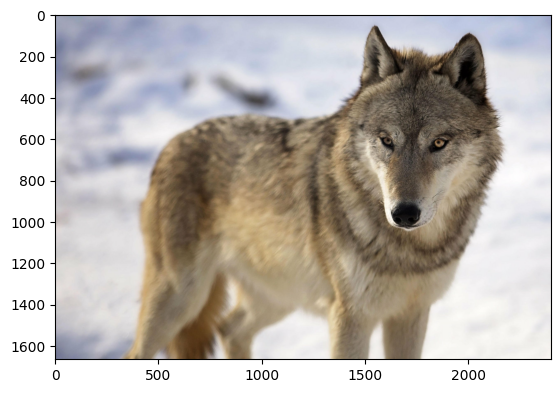

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/wolf_001.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()

1/1 [==============================] - 0s 212ms/step
The name of the fauna is -> zebra
<dtype: 'uint8'>


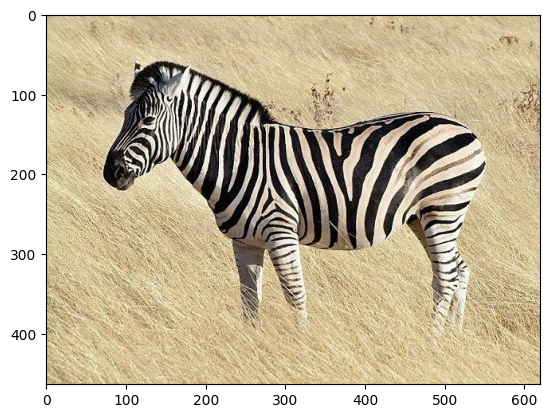

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/zebra_009.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()

1/1 [==============================] - 0s 211ms/step
The name of the fauna is -> brown_bear
<dtype: 'uint8'>


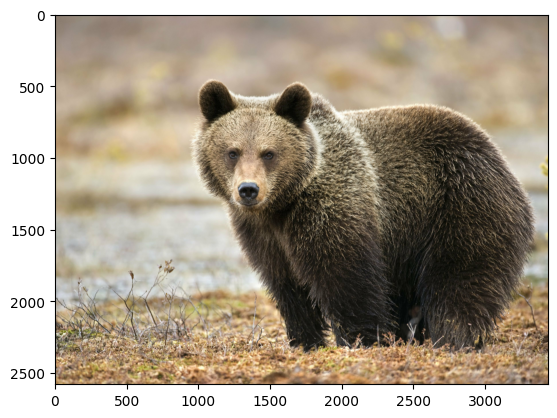

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    animal_name = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]
    return animal_name

img_path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/bearImage.jpg';

# Example usage
animal_name = predict_animal(img_path)
print("The name of the fauna is -> " + animal_name)

from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(img_path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import itertools

# def plot_confusion_matrix(cm, classes,
#              normalize=False,
#              title='Confusion matrix',
#              cmap=plt.cm.Blues):
#     #Add Normalization Option
#     '''prints pretty confusion metric with normalization option '''
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=90)
#     plt.yticks(tick_marks, classes)
    
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')


# # Example usage
# cm = np.array([[10, 20, 30], [40, 50, 60], [70, 80, 90]])
# classes = ['Class 1', 'Class 2', 'Class 3']

# # Create a larger plot
# fig, ax = plt.subplots(figsize=(8, 8))

# plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix')


In [ ]:
# def plot_confusion_matrix(cm, classes,
#              normalize=False,
#              title='Confusion matrix',
#              cmap=plt.cm.Blues):
# #Add Normalization Option
#     '''prints pretty confusion metric with normalization option '''
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
    

#     # fig, ax = plt.subplots(figsize = (10, 8))
#     # ax.imshow(cm, interpolation='nearest', cmap=cmap)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=90)
#     plt.yticks(tick_marks, classes)
    
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [ ]:
# def test_single_image(path):
#     animals = ['bear', 'butterflies', 'cats', 'cheetahs', 'chickens', 'chimpanzee', 'deer', 'dogs', 'elephants', 'goat', 'horses', 'hyenas', 'ox', 'panda', 'rhinoceros', 'spiders', 'squirells', 'tigers', 'wolf', 'zebra']
#     images = read_image(path)
#     time.sleep(.5)
#     bt_prediction = vgg16.predict(images)  

#     # img=img/255
#     # img=np.expand_dims(img,[0])
#     # answer=model1.predict(img)
#     # y_class = answer.argmax(axis=-1)
#     # y = " ".join(str(x) for x in y_class)
#     # y = int(y)
#     # res = lab[y]
#     # return res

#     # preds = model.predict_proba(bt_prediction)
#     # preds = np.argmax(model.predict(bt_prediction), axis=-1)

#     preds = model.predict(bt_prediction)
#     preds = np.argmax(preds, axis=-1)

#     for idx, animal, x in zip(range(0,9), animals , range(preds[0])):
#         print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
#     print('Final Decision:')
#     time.sleep(.5)
#     for x in range(3):
#         print('.'*(x+1))
#         time.sleep(.2)
#     # class_predicted = model.predict_classes(bt_prediction)
#     class_predicted = np.argmax(model.predict(bt_prediction), axis=-1)
#     class_dictionary = generator_top.class_indices  
#     inv_map = {v: k for k, v in class_dictionary.items()}  
#     print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
#     return load_img(path)

#     # predict_prob=model.predict(bt_prediction)
#     # preds=np.argmax(predict_prob,axis=1)


# # def test_single_image(path):
# #     animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
# #     images = read_image(path)
# #     time.sleep(.5)
# #     bt_prediction = vgg16.predict(images)  
# #     preds = model.predict_proba(bt_prediction)
# #     for idx, animal, x in zip(range(0,6), animals , preds[0]):
# #         print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
# #     print('Final Decision:')
# #     time.sleep(.5)
# #     for x in range(3):
# #         print('.'*(x+1))
# #         time.sleep(.2)
# #     # class_predicted = model.predict_classes(bt_prediction)
# #     class_predicted = np.argmax(model.predict(bt_prediction), axis = -1)
# #     class_dictionary = generator_top.class_indices  
# #     inv_map = {v: k for k, v in class_dictionary.items()}  
# #     print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
# #     return load_img(path)

In [ ]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator

#path of image that is used for testing
path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/testimage3.jpeg'

In [ ]:
# !pip install q keras==2.6.0

In [ ]:
print(keras.__version__)

2.9.0


In [ ]:
# from tensorflow.keras.layers import Input
# vgg_model.add(tf.keras.layers.Dense(9, activation = 'softmax'))

In [ ]:
# test_single_image(path)

In [ ]:
def test_single_image(path):
    animals = ['bear', 'butterflies', 'cats', 'cheetahs', 'chickens', 'chimpanzee', 'deer', 'dogs', 'elephants', 'goat', 'horses', 'hyenas', 'ox', 'panda', 'rhinoceros', 'spiders', 'squirells', 'tigers', 'wolf', 'zebra']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [ ]:
test_single_image(path)

<dtype: 'uint8'>


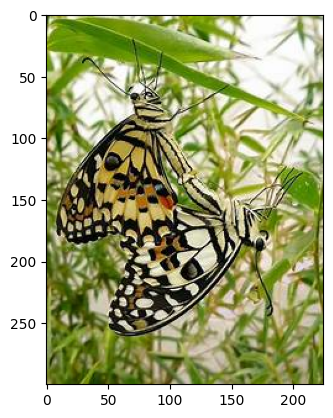

In [ ]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 
filterwarnings("ignore") 
tf_img = io.read_file(path)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()